# EXAMPLES (RAG)
- [RAG](https://docs.activeloop.ai/examples/rag)
  - [RAG Quickstart](https://docs.activeloop.ai/examples/rag/quickstart)
  - [RAG Tutorials](https://docs.activeloop.ai/examples/rag/tutorials)
    - [Vector Store Basics](https://docs.activeloop.ai/examples/rag/tutorials/vector-store-basics)
    - [Vector Search Options](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options)
      - [LangChain API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/langchain-api)
      - [Deep Lake Vector Store API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/vector-store-api)
      - [Managed Database REST API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/rest-api)
    - [Customizing Your Vector Store](https://docs.activeloop.ai/examples/rag/tutorials/step-4-customizing-vector-stores)
    - [**Image Similarity Search**](https://docs.activeloop.ai/examples/rag/tutorials/image-similarity-search)
    - [Improving Search Accuracy using Deep Memory](https://docs.activeloop.ai/examples/rag/tutorials/deepmemory)


## RAG Tutorials (Image Similarity Search)

### Use Deep Lake as a Vector Store for Images
*Deep Lake is a unique Vector Store because it supports storage of various data types including images, video, and audio. In this tutorial we show how to use Deep Lake to perform similarity search for images.*

#### Creating the Vector Store
*We will use ~5k images in the COCO Validation Dataset as a source of diverse images. First, let's download the data.*
- https://cocodataset.org/#home

In [ ]:
# !wget -O "<download_path>" http://images.cocodataset.org/zips/val2017.zip
# MAC !curl -o "<download_path>" http://images.cocodataset.org/zips/val2017.zip

In [2]:
# Unzip the images and specify their parent folder below

# images_path = '/val2017'  # 5000 images
# images_path = './val2017'  # 5000 images
# images_path = '/val2017-100'  # 100 first images
images_path = './val2017-100'  # 100 first images

In [13]:
# Define a ResNet18 PyTorch model to embed the images based on the output from the second-to-last layer

from deeplake.core.vectorstore.deeplake_vectorstore import VectorStore
# from deeplake.core.vectorstore import VectorStore
import os
from dotenv import load_dotenv
import torch
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

load_dotenv(override = True)
open_api_key = os.getenv('OPENAI_API_KEY')
activeloop_token = os.getenv('ACTIVELOOP_TOKEN')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
model = models.resnet18(pretrained=True)

return_nodes = {
    'avgpool': 'embedding'
}
model = create_feature_extractor(model, return_nodes=return_nodes)

model.eval()
model.to(device)

C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [7]:
# Define an embedding function that will embed a list of image filenames and return a list of embeddings.
#   A transformation must be applied to the images so they can be fed into the model, including handling of grayscale images.

tform= transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def embedding_function(images, model = model, transform = tform, batch_size = 4):
    """Creates a list of embeddings based on a list of image filenames. Images are processed in batches."""

    if isinstance(images, str):
        images = [images]

    #Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack([transform(Image.open(item)) for item in images[i:i+batch_size]])
        batch = batch.to(device)
        with torch.no_grad():
            embeddings+= model(batch)['embedding'][:,:,0,0].cpu().numpy().tolist()

    return embeddings

In [14]:
# Create the vector store for storing the data. The Vector Store does not have the default configuration with
#   text, embedding, and metadata tensors, so we use the tensor_params input to define the structure of the Vector Store.

# vector_store_path = 'hub://<org_id>/<dataset_name>'
vector_store_path = 'hub://pavelkloscz/val2017-100'

vector_store = VectorStore(
    path = vector_store_path,
    tensor_params = [{'name': 'image', 'htype': 'image', 'sample_compression': 'jpg'}, 
                     {'name': 'embedding', 'htype': 'embedding'}, 
                     {'name': 'filename', 'htype': 'text'}],
)

Your Deep Lake dataset has been successfully created!


In [15]:
# Create a list of images from the source data and add it to the vector store

image_fns = [os.path.join(images_path, item) for item in os.listdir(images_path) if os.path.splitext(item)[-1]=='.jpg']

In [17]:
len(image_fns)

100

In [18]:
vector_store.add(image = image_fns,
                 filename = image_fns,
                 embedding_function = embedding_function, 
                 embedding_data = image_fns)

C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\deeplake\core\chunk\base_chunk.py:422: UserWarning: Grayscale images will be reshaped from (H, W) to (H, W, 1) to match tensor dimensions. This warning will be shown only once.
  warnings.warn(message)
Creating 100 embeddings in 1 batches of size 100:: 100%|█████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.25s/it]

Dataset(path='hub://pavelkloscz/val2017-100', tensors=['image', 'embedding', 'filename', 'id'])

  tensor      htype               shape               dtype  compression
  -------    -------             -------             -------  ------- 
   image      image    (100, 240:640, 320:640, 1:3)   uint8    jpeg   
 embedding  embedding           (100, 512)           float32   None   
 filename     text               (100, 1)              str     None   
    id        text               (100, 1)              str     None   


In [ ]:
# Automatically printed summary that the Vector Store has tensors for the image, their filename, their embedding, and an id, with 5000 samples each.
# This summary is also available via vector_store.summary().

In [19]:
vector_store.summary()

Dataset(path='hub://pavelkloscz/val2017-100', tensors=['image', 'embedding', 'filename', 'id'])

  tensor      htype               shape               dtype  compression
  -------    -------             -------             -------  ------- 
   image      image    (100, 240:640, 320:640, 1:3)   uint8    jpeg   
 embedding  embedding           (100, 512)           float32   None   
 filename     text               (100, 1)              str     None   
    id        text               (100, 1)              str     None   


#### Similarity Search

In [20]:
# Perform a similarity search on a reference image to find similar images in our Vector Store. First we download the image
# - https://content.gitbook.com/content/WOs95B2h3lcO4dwXDRJ3/blobs/f1x74JEyLY6bO7eaTQG9/image_similarity.jpg

# image_path = '/image_similarity.jpg'
image_path = './image_similarity.jpg'

result = vector_store.search(embedding_data = [image_path], embedding_function = embedding_function)

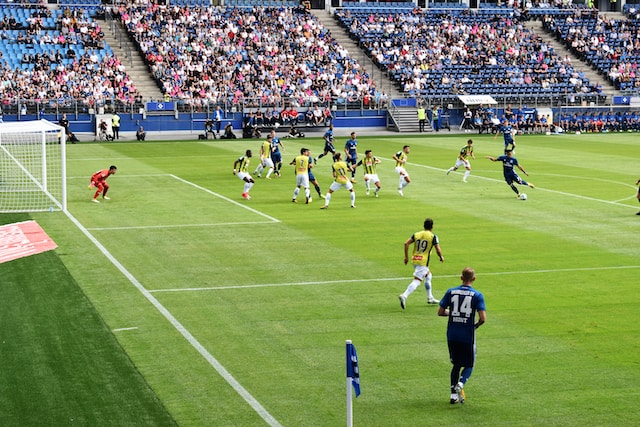

In [21]:
# Display the reference image

image_similarity = Image.open(image_path)
display(image_similarity)

In [24]:
# The key-value pairs in the result contains the tensor as the key and a list of values for the data
result.keys()  # Returns: dict_keys(['filename', 'id', 'image', 'score'])

dict_keys(['score', 'image', 'filename', 'id'])

In [25]:
len(result['score'])  # Returns: 4

4

In [26]:
result['image'][0].shape  # Returns: (427, 640, 3)

(480, 640, 3)

In [27]:
# Since images can be quite large, and we may not want to return them as numpy arrays, so we use return_tensors
#   to specify that only the filename and id tensors should be returned.

result = vector_store.search(embedding_data = image_path, 
                             embedding_function = embedding_function,
                             return_tensors = ['id', 'filename'])

In [28]:
result.keys()  # Returns: dict_keys(['filename', 'id', 'image', 'score'])

dict_keys(['score', 'id', 'filename'])

#### Visualizing the Similarity Results

In [29]:
# Instead of returning the results of the similarity search directly, we can use return_view = True to get the Deep Lake dataset view,
#   which is a lazy pointer to the underlying data that satisfies the similarity search (no data is retrieved locally).

view = vector_store.search(embedding_data = image_path, 
                             embedding_function = embedding_function, 
                             return_view = True)

In [34]:
# We can save the view and visualize it in the Deep Lake UI.

# view.save_view()
# ERROR:
# The dataset's HEAD node has uncommitted changes.
# Please create a commit on the dataset object [ds.commit(<insert optional message>)] prior to saving the view.

# Get the underlying dataset from the view
dataset = vector_store.dataset

# Commit changes to the dataset
dataset.commit("Committing changes before saving view")

# Then save the view
view.save_view()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.42it/s]
 

'hub://pavelkloscz/val2017-100/.queries/ef682b73f6938424c8cc7117359cf7c43df312b69d1568d3f9abb6d97d0e250f'

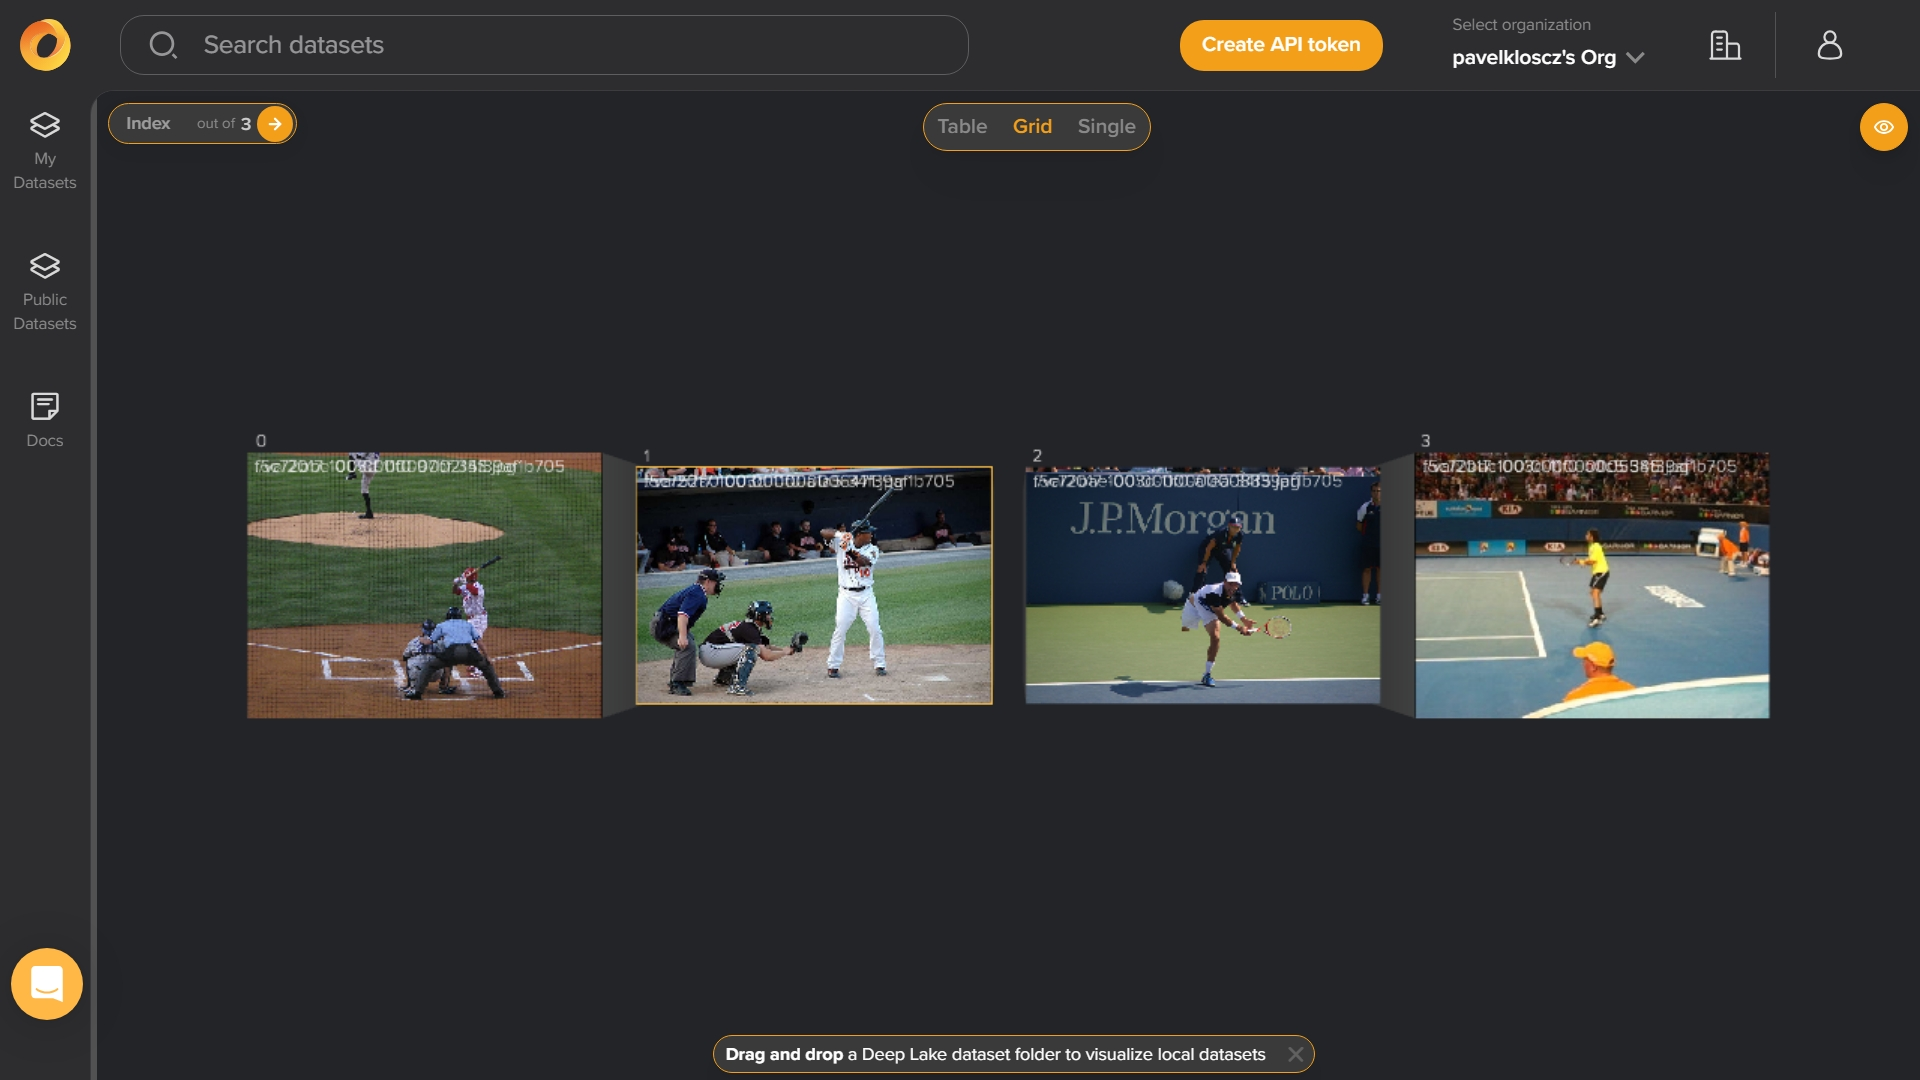

In [35]:
image_similarity_result_view = Image.open('./image_similarity_result_view.jpg')
display(image_similarity_result_view)